# All Activity Bar Graphs

This generates the data for all activity bar graphs for i-modulons in PRECISE 1.0 so that they can be plotted in the ModulomeVis site.

In [1]:
import sys
# be sure that this points to a clone of github.com/SBRG/ICA
sys.path.append('../../../ica/') 
from icaviz.plotting import *
DATA_DIR = '../../../ica/data/precise_data/'
GENE_DIR = '../../../ica/data/annotation/'
enrich = pd.read_csv(DATA_DIR+'curated_enrichments.csv', index_col = 0)
names = enrich['name'].tolist()
ica_data = load_data(X=DATA_DIR+'log_tpm.csv',
                     S=DATA_DIR+'S.csv',
                     A=DATA_DIR+'A.csv',
                     metadata=DATA_DIR+'metadata.csv',
                     annotation=GENE_DIR+'gene_info.csv',
                     trn=GENE_DIR+'TRN.csv',
                     fasta=GENE_DIR+'NC_000913.3.fasta',
                     cutoff = 550)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from activity_bar import *

## Starting point: Anand's example

In [3]:
def plot_samples_bar(ica_data,k,ax):
    
    # Define sort function for conditions
    def keyfxn(x):
        name = x[0]
        match = re.match('^.+?ale(\d+)$',name)
        if match:
            return '{:02d}'.format(int(match.group(1)))
        elif name.startswith('wt') or name.startswith('glu4'):
            return '00'+name[3:]
        else:
            return name

    # Set order for display
    proj_order = ica_data.metadata.project_id.drop_duplicates()
    rename = {'control':'','fur':'Iron','acid':'Acid\n','oxidative':'Oxid.',
              'nac_ntrc':'Nac/\nNtrC','ompr':'OmpR\n','misc':'Misc','omics':'Omics',
              'minspan':'MinSpan','cra_crp':'Cra/\nCrp','rpoB':'RpoB\nKnock-in',
              'crp':'Crp\nARs','glu':'Glucose\nEvol.',
              '42c':'42C\nEvol.','ssw':'Substrate-\nswitching Evol.',
              'pgi':'PGI KO\nEvol.','ica':'Current\nStudy','ytf':'Unchar.\nTFs',
              'efeU':'Pseudogene\nRepair','pal':'Enz.\nPromisc.','fps':'False\nPos.'}
    
    
    list2struct = []
    for proj in proj_order:
        group1 = ica_data.metadata[ica_data.metadata.project_id == proj]
        for cond,group2 in sorted(group1.groupby('condition_id'),key=keyfxn):
            for name in group2.index:
                list2struct.append([proj,cond,ica_data.A.loc[k,name],len(group2)])
    DF_comp = pd.DataFrame(list2struct,columns = ['project_id','condition_id','value','length'])
    DF_comp['width'] = 1/DF_comp.length
    DF_comp.index = [0]+np.cumsum(DF_comp.width).tolist()[:-1]

    # Get xlabels and tick marks
    xticks = []
    xticklabels = []
    vlines = []
    proj_labels = []
    proj_locs = []
    for proj,group1 in DF_comp.groupby('project_id'):
        vlines.append(min(group1.index))
        proj_labels.append(rename[proj])
        proj_locs.append(min(group1.index)+group1.width.sum()/2)
        for cond,group2 in group1.groupby('condition_id'):
            xticks.append(np.mean(group2.index)+np.mean(group2.width)/2)
            xticklabels.append(cond)
    
    # Add alternating gray rectangles in back
    for i in np.arange(0,len(DF_comp),2):
        ax.add_patch(Rectangle((i,-100),1,200,color='#888888',alpha=0.1))
    
    
    # Draw bar chart
    ax.bar(DF_comp.index,DF_comp.value,width = DF_comp.width,align='edge',linewidth=0)
    
    # Set x axis parameters
    ax.set_xlim([0,len(DF_comp)])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=4)
    ax.tick_params(axis='x',which='major',direction='in',length=4,labelrotation=90)
    ax.tick_params(axis='y',labelsize=7)
    ax.grid(False,which='major')
    
    # Add vertical bars to designate project
    ax.vlines(vlines,-100,100,colors='#888888',linewidth=1)
    ax.set_ylim(min(DF_comp.value)*1.2,max(DF_comp.value)*1.2)
    ax.set_xlim(DF_comp.index.min(),DF_comp.index.max()+DF_comp.width.iloc[-1])
    ax.set_ylabel('I-Modulon Activity',fontsize=6)


    # Add project labels
    ax2 = ax.twiny()
    ax2.grid(False)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(proj_locs)
    ax2.set_xticklabels(proj_labels,fontsize=7)
    ax2.tick_params(axis='x',length=0)
    ax2.xaxis.tick_top()
    
    # Add top and bottom labels
    ax.set_xlabel('Condition\nID',x=-0.05,va='bottom',fontsize=9,labelpad=-5)
    ax2.set_xlabel('Study',x=-0.05,va='top',fontsize=9,labelpad=3)
    
    return ax

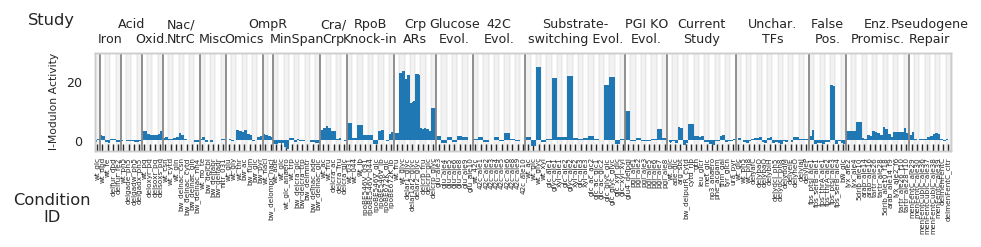

In [8]:
fig, ax = plt.subplots(figsize = (8.5, 1), dpi=130)
ax = plot_samples_bar(ica_data, 1, ax)

## Working below

In [13]:
# public metadata table

# drop the stuff the public doesn't need to see
sample_meta = ica_data.metadata.drop(['contact', 'library creator', 'run_date', 'R1', 'R2', 'BAM', 'alignment', 'Public'], axis=1)

# fix a minor issue with the number of biological replicates in a condition
sample_meta.loc[(sample_meta.project_id == 'ica') & (sample_meta.condition_id == 'wt_glc'), 'Biological Replicates'] = [6]*6

# reset index so that javascript can deal more easily (as numerically indexed arrays)
sample_meta = sample_meta.reset_index()

sample_meta.to_csv('data/sample_metadata.csv')

sample_meta

,sample_id,study,project_id,condition_id,rep_id,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,DOI,GEO
0,control__wt_glc__1,Control,control,wt_glc,1,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,NaN,No,NaN,MiSeq,NaN,2,doi.org/10.1101/080929,GSE65643
1,control__wt_glc__2,Control,control,wt_glc,2,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,NaN,No,NaN,MiSeq,NaN,2,doi.org/10.1101/080929,GSE65643
2,fur__wt_dpd__1,Fur,fur,wt_dpd,1,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,DPD (0.2mM),37,7.0,NaN,Batch,0.00,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
3,fur__wt_dpd__2,Fur,fur,wt_dpd,2,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,DPD (0.2mM),37,7.0,NaN,Batch,0.00,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
4,fur__wt_fe__1,Fur,fur,wt_fe,1,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,FeCl2 (0.1mM),37,7.0,NaN,Batch,1.06,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
5,fur__wt_fe__2,Fur,fur,wt_fe,2,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,FeCl2 (0.1mM),37,7.0,NaN,Batch,1.06,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
6,fur__delfur_dpd__1,Fur,fur,delfur_dpd,1,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,DPD (0.2mM),37,7.0,Kanamycin (50 ug/mL),Batch,0.00,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
7,fur__delfur_dpd__2,Fur,fur,delfur_dpd,2,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,DPD (0.2mM),37,7.0,Kanamycin (50 ug/mL),Batch,0.00,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
8,fur__delfur_fe2__1,Fur,fur,delfur_fe2,1,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,FeCl2 (0.1mM),37,7.0,Kanamycin (50 ug/mL),Batch,0.62,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900
9,fur__delfur_fe2__2,Fur,fur,delfur_fe2,2,Escherichia coli K-12 MG1655 del_fur,MG1655,M9,glucose(2),NH4Cl(1),O2,NaN,FeCl2 (0.1mM),37,7.0,Kanamycin (50 ug/mL),Batch,0.62,No,NaN,MiSeq,NaN,2,doi.org/10.1038/ncomms5910,GSE54900


In [9]:
def metadata_disagreement_check(sample_meta, ignored_cols):
    '''
    input: sample_meta, [samples x features], which contains 'project_id',
                        'condition_id', and 'Biological Replicates' as columns
           ignored_cols, columns of sample_meta that are expected to be different within conditions
    output: displays conditions (groups of samples) with disagreements in other features, which will
            need to be reconciled if these columns are meant to describe the entire condition.
    '''
    # get the features to iterate through
    meta_columns = sample_meta.columns.to_list()
    for col in ignored_cols:
        meta_columns.remove(col)
    
    # find the disagreements
    for cond, group in sample_meta.groupby(['project_id','condition_id'], sort = False):
        cond_name = cond[0]+'__'+cond[1] # project__cond
        dis = False
        for meta_col in meta_columns:
            if (group[meta_col].isna().any()):# nans
                if not(group[meta_col].isna().all()): # if one is nan, all should be nan
                    dis = True
                    print('Disagreement:', cond_name, meta_col)
            else: # all rows have values
                if (group.loc[group.index[0], meta_col] != group[meta_col]).any():
                    dis = True
                    print('Disagreement:', cond_name, meta_col)
            
            if meta_col == 'Biological Replicates': # one extra check here
                if group.loc[group.index[0], meta_col] != len(group.index):
                    dis = True
                    print('Disagreement in number of replicates:', cond_name, len(group.index))
        if dis:
            display(group)

In [14]:
ignored_cols = ['sample_id','rep_id','condition_id',
                'Sequencing Machine','Growth Rate (1/hr)',
                'Additional Details']
metadata_disagreement_check(sample_meta, ignored_cols)

Disagreement: minspan__wt_glc DOI
Disagreement: minspan__wt_glc GEO


,sample_id,study,project_id,condition_id,rep_id,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,DOI,GEO
68,minspan__wt_glc__1,MinSpan,minspan,wt_glc,1,Escherichia coli K-12 MG1655,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,NaN,No,NaN,GAIIX,NaN,4,doi.org/10.15252/msb.20145243,GSE48324
69,minspan__wt_glc__2,MinSpan,minspan,wt_glc,2,Escherichia coli K-12 MG1655,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,NaN,No,NaN,GAIIX,NaN,4,doi.org/10.15252/msb.20145243,GSE48324
70,minspan__wt_glc__3,MinSpan,minspan,wt_glc,3,Escherichia coli K-12 MG1655,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,NaN,No,NaN,GAIIX,NaN,4,doi.org/10.15252/msb.20145243,GSE48324
71,minspan__wt_glc__4,MinSpan,minspan,wt_glc,4,Escherichia coli K-12 MG1655,MG1655,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,NaN,No,NaN,MiSeq,Bridging Study between MiSeq & GAIIX,4,NaN,GSE122211


Disagreement: minspan__bw_delcra_glc DOI
Disagreement: minspan__bw_delcra_glc GEO


,sample_id,study,project_id,condition_id,rep_id,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,DOI,GEO
75,minspan__bw_delcra_glc__1,MinSpan,minspan,bw_delcra_glc,1,Escherichia coli BW25113 del_cra,BW25113,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,Kanamycin,Batch,NaN,No,NaN,GAIIX,NaN,2,doi.org/10.15252/msb.20145243,GSE48324
76,minspan__bw_delcra_glc__2,MinSpan,minspan,bw_delcra_glc,2,Escherichia coli BW25113 del_cra,BW25113,M9,glucose(4),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,Kanamycin,Batch,NaN,No,NaN,MiSeq,Bridging Study between MiSeq & GAIIX,2,NaN,GSE122211


Disagreement: ica__wt_glc GEO


,sample_id,study,project_id,condition_id,rep_id,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,Trace Element Mixture,Supplement,Temperature (C),pH,Antibiotic,Culture Type,Growth Rate (1/hr),Evolved Sample,Isolate Type,Sequencing Machine,Additional Details,Biological Replicates,DOI,GEO
168,ica__wt_glc__1,ICA,ica,wt_glc,1,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,0.58,No,NaN,HiSeq 4000,NaN,6,NaN,GSE122295
169,ica__wt_glc__2,ICA,ica,wt_glc,2,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,0.58,No,NaN,HiSeq 4000,NaN,6,NaN,GSE122295
170,ica__wt_glc__3,ICA,ica,wt_glc,3,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,0.66,No,NaN,HiSeq 4000,NaN,6,NaN,GSE122295
171,ica__wt_glc__4,ICA,ica,wt_glc,4,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,0.66,No,NaN,HiSeq 4000,NaN,6,NaN,GSE122295
192,ica__wt_glc__5,ICA,ica,wt_glc,5,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,0.63,No,NaN,HiSeq 4000,NaN,6,NaN,NaN
193,ica__wt_glc__6,ICA,ica,wt_glc,6,Escherichia coli K-12 MG1655,MG1655,M9,glucose(2),NH4Cl(1),O2,sauer trace element mixture,NaN,37,7.0,NaN,Batch,0.63,No,NaN,HiSeq 4000,NaN,6,NaN,NaN


Based on the output above, it looks like DOI and GEO for replicate #1 should be representative of a condition

In [25]:
from itertools import chain
def activity_bar_df(ica_data, k):
    '''
    input: ica_data, from github.com/SBRG/ICA
           k, the i-modulon's index
    output: a dataframe for producing the activity bar graph in javascript
    '''
    
    # get the row of A
    A_k = ica_data.A.loc[k]

    # initialize the dataframe
    max_replicates = sample_meta['Biological Replicates'].max()
    columns = ['A_avg', 'A_std', 'n'] + list(chain(*[['rep%i_idx'%(i), 'rep%i_A'%(i)] for i in range(1, max_replicates+1)]))
    res = pd.DataFrame(columns = columns)

    # iterate through conditions and fill in rows
    for cond, group in sample_meta.groupby(['project_id','condition_id'], sort = False):
        
        # get condition name and A values
        cond_name = cond[0]+'__'+cond[1] # project__cond
        vals = A_k[group.sample_id]
        
        # compute statistics
        new_row = [vals.mean(), vals.std(), len(vals)]
        
        # fill in individual samples (indices and values)
        for idx in group.index:
            new_row += [idx, vals[group.sample_id[idx]]]
        new_row += [np.nan]*((max_replicates-len(vals))*2)

        res.loc[cond_name] = new_row
    
    # clean up
    res.index.name = 'condition'
    res = res.reset_index()
    
    return res

## Generate all CSVs

In [27]:
data_folder = 'data/'
for k, row in enrich.iterrows():
    this_fig = activity_bar_df(ica_data, k)
    this_fig.to_csv(data_folder + '%i_activity_bar.csv'%(k))
    